In [8]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [9]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir(r'E:\dataset\Hand Gesture Dataset\leapGestRecog\00'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

In [11]:
x_data = []
y_data = []
IMG_SIZE = 150
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir(r'E:\dataset\Hand Gesture Dataset\leapGestRecog\0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir(r'E:\dataset\Hand Gesture Dataset\leapGestRecog\0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                path = r'E:\dataset\Hand Gesture Dataset\leapGestRecog\0' + str(i) + '/' + j + '/' + k
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

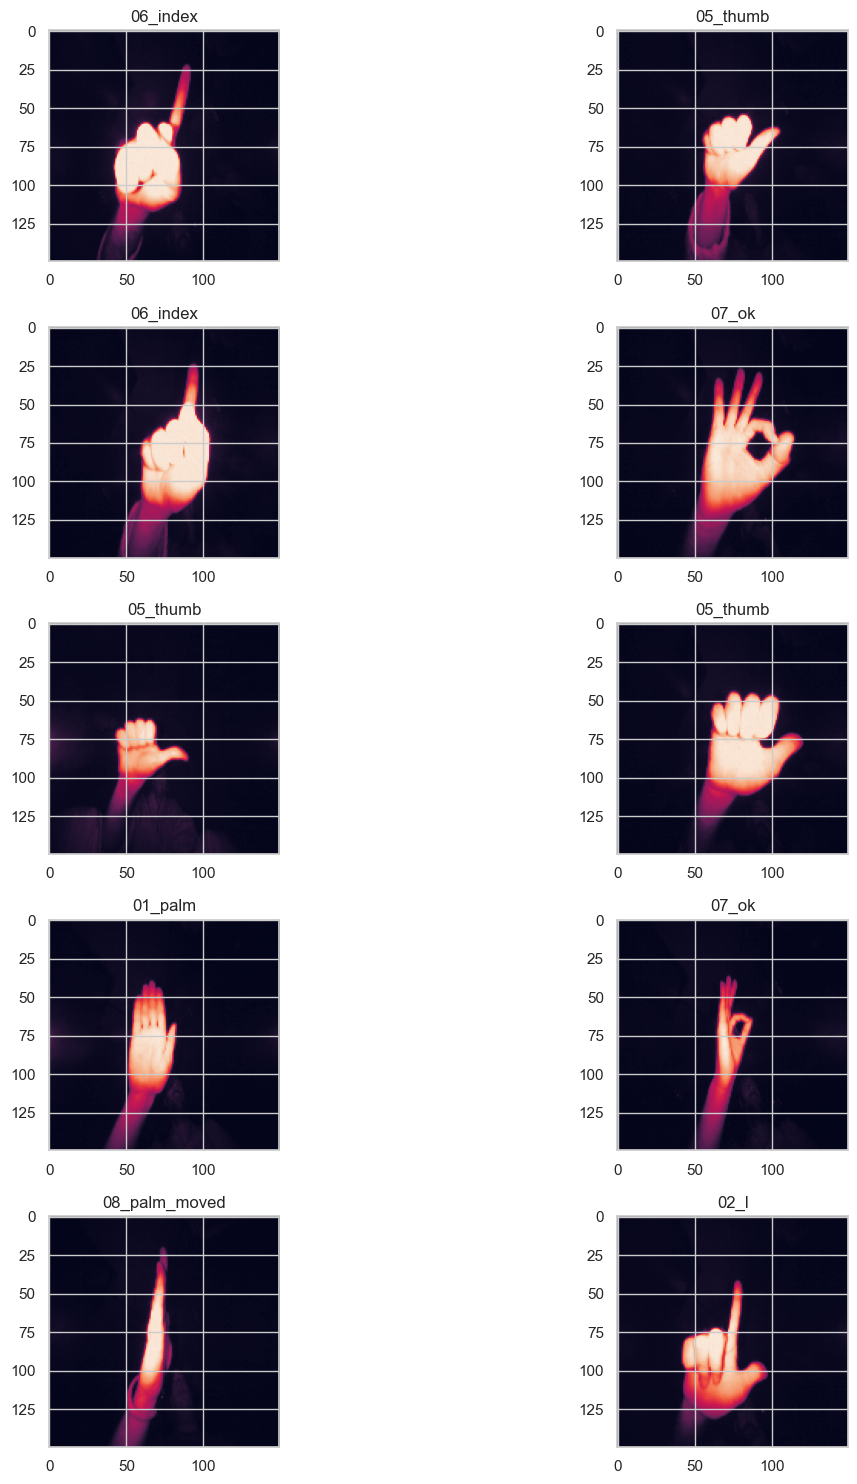

In [12]:
# check some image
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y_data))
        ax[i,j].imshow(x_data[l])
        ax[i,j].set_title(reverselookup[y_data[l,0]])
        
plt.tight_layout()

In [13]:
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data/255

In [14]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.25,random_state=42)

In [15]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10, activation = "softmax"))

In [16]:
batch_size=128
epochs=3

In [17]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    mode='min',
    save_weights_only=False,
    save_freq=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [18]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 96)        0

In [20]:
History = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test),callbacks=callbacks)

Epoch 1/3



Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  1/118 [..............................] - ETA: 21:44 - loss: 2.3039 - accuracy: 0.1016
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  2/118 [..............................] - ETA: 5:56 - loss: 2.2984 - accuracy: 0.1055 
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  3/118 [..............................] - ETA: 5:39 - loss: 2.2793 - accuracy: 0.1042
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  4/118 [>.............................] - ETA: 5:33 - loss: 2.2687 - accuracy: 0.1172
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  5/118 [>.............................] - ETA: 5:26 - loss: 2.2403 - accuracy: 0.1688
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  6/118 [>.............................] - ETA: 5:20 - loss: 2.1943 - accuracy: 0.1953
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  7/118 [>.............................] - ETA: 5:18 - loss: 2.1529 - accuracy: 0.2109
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  8/118 [=>............................] - ETA: 5:15 - loss: 2.0987 - accuracy: 0.2354
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  9/118 [=>............................] - ETA: 5:13 - loss: 2.0363 - accuracy: 0.2595
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 10/118 [=>............................] - ETA: 5:09 - loss: 1.9662 - accuracy: 0.2898
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 11/118 [=>............................] - ETA: 5:06 - loss: 1.9081 - accuracy: 0.3111
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 12/118 [==>...........................] - ETA: 5:02 - loss: 1.8976 - accuracy: 0.3327
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 13/118 [==>...........................] - ETA: 4:55 - loss: 1.8682 - accuracy: 0.3413
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 14/118 [==>...........................] - ETA: 4:52 - loss: 1.8233 - accuracy: 0.3532
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 15/118 [==>...........................] - ETA: 4:50 - loss: 1.7938 - accuracy: 0.3672
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 16/118 [===>..........................] - ETA: 4:48 - loss: 1.7640 - accuracy: 0.3804
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 17/118 [===>..........................] - ETA: 4:45 - loss: 1.7240 - accuracy: 0.3989
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 18/118 [===>..........................] - ETA: 4:42 - loss: 1.6830 - accuracy: 0.4175
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 19/118 [===>..........................] - ETA: 4:40 - loss: 1.6485 - accuracy: 0.4301
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 20/118 [====>.........................] - ETA: 4:37 - loss: 1.6148 - accuracy: 0.4430
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 21/118 [====>.........................] - ETA: 4:33 - loss: 1.5781 - accuracy: 0.4583
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 22/118 [====>.........................] - ETA: 4:30 - loss: 1.5324 - accuracy: 0.4755
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 23/118 [====>.........................] - ETA: 4:27 - loss: 1.5000 - accuracy: 0.4878
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 24/118 [=====>........................] - ETA: 4:24 - loss: 1.4707 - accuracy: 0.4993
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 25/118 [=====>........................] - ETA: 4:21 - loss: 1.4310 - accuracy: 0.5156
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 26/118 [=====>........................] - ETA: 4:18 - loss: 1.4026 - accuracy: 0.5276
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 27/118 [=====>........................] - ETA: 4:15 - loss: 1.3714 - accuracy: 0.5402
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 28/118 [======>.......................] - ETA: 4:12 - loss: 1.3429 - accuracy: 0.5513
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 29/118 [======>.......................] - ETA: 4:09 - loss: 1.3223 - accuracy: 0.5579
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 30/118 [======>.......................] - ETA: 4:06 - loss: 1.2902 - accuracy: 0.5690
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 31/118 [======>.......................] - ETA: 4:03 - loss: 1.2601 - accuracy: 0.5789
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 32/118 [=======>......................] - ETA: 4:00 - loss: 1.2349 - accuracy: 0.5869
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 33/118 [=======>......................] - ETA: 3:58 - loss: 1.2111 - accuracy: 0.5954
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 34/118 [=======>......................] - ETA: 3:55 - loss: 1.1858 - accuracy: 0.6048
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 35/118 [=======>......................] - ETA: 3:52 - loss: 1.1622 - accuracy: 0.6134
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 36/118 [========>.....................] - ETA: 3:49 - loss: 1.1377 - accuracy: 0.6222
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 37/118 [========>.....................] - ETA: 3:47 - loss: 1.1127 - accuracy: 0.6311
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 38/118 [========>.....................] - ETA: 3:43 - loss: 1.0897 - accuracy: 0.6394
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 39/118 [========>.....................] - ETA: 3:41 - loss: 1.0664 - accuracy: 0.6474
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 40/118 [=========>....................] - ETA: 3:38 - loss: 1.0433 - accuracy: 0.6555
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 41/118 [=========>....................] - ETA: 3:35 - loss: 1.0238 - accuracy: 0.6622
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 42/118 [=========>....................] - ETA: 3:33 - loss: 1.0023 - accuracy: 0.6691
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 43/118 [=========>....................] - ETA: 3:30 - loss: 0.9814 - accuracy: 0.6761
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 44/118 [==========>...................] - ETA: 3:28 - loss: 0.9629 - accuracy: 0.6824
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 45/118 [==========>...................] - ETA: 3:25 - loss: 0.9442 - accuracy: 0.6887
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 46/118 [==========>...................] - ETA: 3:22 - loss: 0.9251 - accuracy: 0.6953
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 47/118 [==========>...................] - ETA: 3:19 - loss: 0.9094 - accuracy: 0.6995
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 48/118 [===========>..................] - ETA: 3:17 - loss: 0.8930 - accuracy: 0.7056
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 49/118 [===========>..................] - ETA: 3:14 - loss: 0.8801 - accuracy: 0.7103
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 50/118 [===========>..................] - ETA: 3:11 - loss: 0.8671 - accuracy: 0.7148
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 51/118 [===========>..................] - ETA: 3:08 - loss: 0.8511 - accuracy: 0.7201
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 52/118 [============>.................] - ETA: 3:06 - loss: 0.8383 - accuracy: 0.7245
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 53/118 [============>.................] - ETA: 3:03 - loss: 0.8253 - accuracy: 0.7291
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 54/118 [============>.................] - ETA: 3:00 - loss: 0.8111 - accuracy: 0.7338
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 55/118 [============>.................] - ETA: 2:57 - loss: 0.7989 - accuracy: 0.7381
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 56/118 [=============>................] - ETA: 2:54 - loss: 0.7861 - accuracy: 0.7422
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 57/118 [=============>................] - ETA: 2:51 - loss: 0.7735 - accuracy: 0.7463
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 58/118 [=============>................] - ETA: 2:49 - loss: 0.7619 - accuracy: 0.7504
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 59/118 [==============>...............] - ETA: 2:46 - loss: 0.7501 - accuracy: 0.7542
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 60/118 [==============>...............] - ETA: 2:43 - loss: 0.7381 - accuracy: 0.7582
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 61/118 [==============>...............] - ETA: 2:40 - loss: 0.7267 - accuracy: 0.7620
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 62/118 [==============>...............] - ETA: 2:37 - loss: 0.7161 - accuracy: 0.7652
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 63/118 [===============>..............] - ETA: 2:34 - loss: 0.7050 - accuracy: 0.7690
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 64/118 [===============>..............] - ETA: 2:32 - loss: 0.6944 - accuracy: 0.7725
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 65/118 [===============>..............] - ETA: 2:29 - loss: 0.6845 - accuracy: 0.7757
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 66/118 [===============>..............] - ETA: 2:26 - loss: 0.6752 - accuracy: 0.7788
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 67/118 [================>.............] - ETA: 2:23 - loss: 0.6656 - accuracy: 0.7819
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 68/118 [================>.............] - ETA: 2:20 - loss: 0.6561 - accuracy: 0.7850
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 69/118 [================>.............] - ETA: 2:18 - loss: 0.6469 - accuracy: 0.7880
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 70/118 [================>.............] - ETA: 2:15 - loss: 0.6379 - accuracy: 0.7911
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 71/118 [=================>............] - ETA: 2:13 - loss: 0.6293 - accuracy: 0.7940
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 72/118 [=================>............] - ETA: 2:10 - loss: 0.6207 - accuracy: 0.7969
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 73/118 [=================>............] - ETA: 2:07 - loss: 0.6124 - accuracy: 0.7997
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 74/118 [=================>............] - ETA: 2:05 - loss: 0.6044 - accuracy: 0.8023
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 75/118 [==================>...........] - ETA: 2:02 - loss: 0.5966 - accuracy: 0.8049
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 76/118 [==================>...........] - ETA: 1:59 - loss: 0.5888 - accuracy: 0.8075
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 77/118 [==================>...........] - ETA: 1:56 - loss: 0.5813 - accuracy: 0.8100
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 78/118 [==================>...........] - ETA: 1:54 - loss: 0.5740 - accuracy: 0.8124
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 79/118 [===================>..........] - ETA: 1:51 - loss: 0.5671 - accuracy: 0.8147
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 80/118 [===================>..........] - ETA: 1:48 - loss: 0.5604 - accuracy: 0.8168
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 81/118 [===================>..........] - ETA: 1:45 - loss: 0.5536 - accuracy: 0.8191
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 82/118 [===================>..........] - ETA: 1:42 - loss: 0.5468 - accuracy: 0.8213
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 83/118 [====================>.........] - ETA: 1:40 - loss: 0.5404 - accuracy: 0.8234
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 84/118 [====================>.........] - ETA: 1:37 - loss: 0.5341 - accuracy: 0.8254
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 85/118 [====================>.........] - ETA: 1:34 - loss: 0.5287 - accuracy: 0.8274
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 86/118 [====================>.........] - ETA: 1:31 - loss: 0.5227 - accuracy: 0.8293
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 87/118 [=====================>........] - ETA: 1:28 - loss: 0.5167 - accuracy: 0.8313
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 88/118 [=====================>........] - ETA: 1:25 - loss: 0.5114 - accuracy: 0.8330
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 89/118 [=====================>........] - ETA: 1:22 - loss: 0.5060 - accuracy: 0.8347
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 90/118 [=====================>........] - ETA: 1:20 - loss: 0.5004 - accuracy: 0.8365
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 91/118 [======================>.......] - ETA: 1:17 - loss: 0.4951 - accuracy: 0.8383
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 92/118 [======================>.......] - ETA: 1:14 - loss: 0.4898 - accuracy: 0.8399
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 93/118 [======================>.......] - ETA: 1:11 - loss: 0.4846 - accuracy: 0.8416
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 94/118 [======================>.......] - ETA: 1:08 - loss: 0.4809 - accuracy: 0.8432
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 95/118 [=======================>......] - ETA: 1:05 - loss: 0.4760 - accuracy: 0.8447
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 96/118 [=======================>......] - ETA: 1:03 - loss: 0.4719 - accuracy: 0.8463
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 97/118 [=======================>......] - ETA: 1:00 - loss: 0.4671 - accuracy: 0.8479
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 98/118 [=======================>......] - ETA: 57s - loss: 0.4624 - accuracy: 0.8494 
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 99/118 [========================>.....] - ETA: 54s - loss: 0.4579 - accuracy: 0.8509
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


100/118 [========================>.....] - ETA: 51s - loss: 0.4534 - accuracy: 0.8523
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


101/118 [========================>.....] - ETA: 48s - loss: 0.4493 - accuracy: 0.8537
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


102/118 [========================>.....] - ETA: 45s - loss: 0.4449 - accuracy: 0.8552
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


103/118 [=========================>....] - ETA: 42s - loss: 0.4406 - accuracy: 0.8566
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


104/118 [=========================>....] - ETA: 40s - loss: 0.4366 - accuracy: 0.8579
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


105/118 [=========================>....] - ETA: 37s - loss: 0.4325 - accuracy: 0.8592
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


106/118 [=========================>....] - ETA: 34s - loss: 0.4285 - accuracy: 0.8606
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


107/118 [==========================>...] - ETA: 31s - loss: 0.4245 - accuracy: 0.8619
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


108/118 [==========================>...] - ETA: 28s - loss: 0.4206 - accuracy: 0.8631
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


109/118 [==========================>...] - ETA: 25s - loss: 0.4169 - accuracy: 0.8644
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


110/118 [==========================>...] - ETA: 22s - loss: 0.4131 - accuracy: 0.8656
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


111/118 [===========================>..] - ETA: 20s - loss: 0.4095 - accuracy: 0.8668
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


112/118 [===========================>..] - ETA: 17s - loss: 0.4058 - accuracy: 0.8680
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


113/118 [===========================>..] - ETA: 14s - loss: 0.4025 - accuracy: 0.8691
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


114/118 [===========================>..] - ETA: 11s - loss: 0.3992 - accuracy: 0.8701
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


115/118 [============================>.] - ETA: 8s - loss: 0.3957 - accuracy: 0.8713 
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


116/118 [============================>.] - ETA: 5s - loss: 0.3924 - accuracy: 0.8723
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


117/118 [============================>.] - ETA: 2s - loss: 0.3891 - accuracy: 0.8734
Epoch 1: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


118/118 [==============================] - 357s 3s/step - loss: 0.3887 - accuracy: 0.8735 - val_loss: 0.0162 - val_accuracy: 0.9960 - lr: 0.0010
Epoch 2/3

Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  1/118 [..............................] - ETA: 6:11 - loss: 0.0048 - accuracy: 1.0000
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  2/118 [..............................] - ETA: 5:34 - loss: 0.1147 - accuracy: 0.9648
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  3/118 [..............................] - ETA: 5:25 - loss: 0.0864 - accuracy: 0.9714
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  4/118 [>.............................] - ETA: 5:21 - loss: 0.0678 - accuracy: 0.9785
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  5/118 [>.............................] - ETA: 5:17 - loss: 0.0612 - accuracy: 0.9797
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  6/118 [>.............................] - ETA: 5:07 - loss: 0.0708 - accuracy: 0.9766
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  7/118 [>.............................] - ETA: 5:05 - loss: 0.0692 - accuracy: 0.9766
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  8/118 [=>............................] - ETA: 5:02 - loss: 0.0750 - accuracy: 0.9775
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  9/118 [=>............................] - ETA: 4:59 - loss: 0.0726 - accuracy: 0.9774
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 10/118 [=>............................] - ETA: 4:57 - loss: 0.0728 - accuracy: 0.9773
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 11/118 [=>............................] - ETA: 4:55 - loss: 0.0732 - accuracy: 0.9780
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 12/118 [==>...........................] - ETA: 4:53 - loss: 0.0721 - accuracy: 0.9772
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 13/118 [==>...........................] - ETA: 4:48 - loss: 0.0686 - accuracy: 0.9784
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 14/118 [==>...........................] - ETA: 4:45 - loss: 0.0651 - accuracy: 0.9794
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 15/118 [==>...........................] - ETA: 4:42 - loss: 0.0623 - accuracy: 0.9802
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 16/118 [===>..........................] - ETA: 4:40 - loss: 0.0598 - accuracy: 0.9814
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 17/118 [===>..........................] - ETA: 4:37 - loss: 0.0583 - accuracy: 0.9825
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 18/118 [===>..........................] - ETA: 4:35 - loss: 0.0562 - accuracy: 0.9835
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 19/118 [===>..........................] - ETA: 4:32 - loss: 0.0537 - accuracy: 0.9844
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 20/118 [====>.........................] - ETA: 4:29 - loss: 0.0527 - accuracy: 0.9848
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 21/118 [====>.........................] - ETA: 4:26 - loss: 0.0516 - accuracy: 0.9851
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 22/118 [====>.........................] - ETA: 4:22 - loss: 0.0528 - accuracy: 0.9854
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 23/118 [====>.........................] - ETA: 4:20 - loss: 0.0523 - accuracy: 0.9857
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 24/118 [=====>........................] - ETA: 4:17 - loss: 0.0505 - accuracy: 0.9863
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 25/118 [=====>........................] - ETA: 4:15 - loss: 0.0488 - accuracy: 0.9869
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 26/118 [=====>........................] - ETA: 4:12 - loss: 0.0490 - accuracy: 0.9868
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 27/118 [=====>........................] - ETA: 4:10 - loss: 0.0475 - accuracy: 0.9873
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 28/118 [======>.......................] - ETA: 4:07 - loss: 0.0462 - accuracy: 0.9877
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 29/118 [======>.......................] - ETA: 4:04 - loss: 0.0448 - accuracy: 0.9881
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 30/118 [======>.......................] - ETA: 4:01 - loss: 0.0452 - accuracy: 0.9880
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 31/118 [======>.......................] - ETA: 3:59 - loss: 0.0441 - accuracy: 0.9882
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 32/118 [=======>......................] - ETA: 3:56 - loss: 0.0445 - accuracy: 0.9883
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 33/118 [=======>......................] - ETA: 3:54 - loss: 0.0440 - accuracy: 0.9882
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 34/118 [=======>......................] - ETA: 3:51 - loss: 0.0428 - accuracy: 0.9885
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 35/118 [=======>......................] - ETA: 3:48 - loss: 0.0427 - accuracy: 0.9886
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 36/118 [========>.....................] - ETA: 3:46 - loss: 0.0419 - accuracy: 0.9889
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 37/118 [========>.....................] - ETA: 3:42 - loss: 0.0409 - accuracy: 0.9892
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 38/118 [========>.....................] - ETA: 3:40 - loss: 0.0400 - accuracy: 0.9895
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 39/118 [========>.....................] - ETA: 3:37 - loss: 0.0391 - accuracy: 0.9898
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 40/118 [=========>....................] - ETA: 3:34 - loss: 0.0382 - accuracy: 0.9900
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 41/118 [=========>....................] - ETA: 3:32 - loss: 0.0374 - accuracy: 0.9903
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 42/118 [=========>....................] - ETA: 3:29 - loss: 0.0366 - accuracy: 0.9905
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 43/118 [=========>....................] - ETA: 3:26 - loss: 0.0360 - accuracy: 0.9906
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 44/118 [==========>...................] - ETA: 3:24 - loss: 0.0353 - accuracy: 0.9908
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 45/118 [==========>...................] - ETA: 3:21 - loss: 0.0345 - accuracy: 0.9910
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 46/118 [==========>...................] - ETA: 3:18 - loss: 0.0338 - accuracy: 0.9912
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 47/118 [==========>...................] - ETA: 3:15 - loss: 0.0331 - accuracy: 0.9914
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 48/118 [===========>..................] - ETA: 3:12 - loss: 0.0324 - accuracy: 0.9915
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 49/118 [===========>..................] - ETA: 3:10 - loss: 0.0318 - accuracy: 0.9917
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 50/118 [===========>..................] - ETA: 3:07 - loss: 0.0312 - accuracy: 0.9919
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 51/118 [===========>..................] - ETA: 3:04 - loss: 0.0307 - accuracy: 0.9920
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 52/118 [============>.................] - ETA: 3:01 - loss: 0.0301 - accuracy: 0.9922
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 53/118 [============>.................] - ETA: 2:59 - loss: 0.0296 - accuracy: 0.9923
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 54/118 [============>.................] - ETA: 2:56 - loss: 0.0291 - accuracy: 0.9925
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 55/118 [============>.................] - ETA: 2:53 - loss: 0.0286 - accuracy: 0.9926
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 56/118 [=============>................] - ETA: 2:50 - loss: 0.0282 - accuracy: 0.9927
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 57/118 [=============>................] - ETA: 2:48 - loss: 0.0278 - accuracy: 0.9929
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 58/118 [=============>................] - ETA: 2:45 - loss: 0.0273 - accuracy: 0.9930
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 59/118 [==============>...............] - ETA: 2:42 - loss: 0.0270 - accuracy: 0.9931
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 60/118 [==============>...............] - ETA: 2:39 - loss: 0.0266 - accuracy: 0.9932
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 61/118 [==============>...............] - ETA: 2:36 - loss: 0.0261 - accuracy: 0.9933
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 62/118 [==============>...............] - ETA: 2:34 - loss: 0.0257 - accuracy: 0.9934
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 63/118 [===============>..............] - ETA: 2:31 - loss: 0.0253 - accuracy: 0.9936
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 64/118 [===============>..............] - ETA: 2:28 - loss: 0.0249 - accuracy: 0.9937
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 65/118 [===============>..............] - ETA: 2:25 - loss: 0.0246 - accuracy: 0.9937
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 66/118 [===============>..............] - ETA: 2:22 - loss: 0.0242 - accuracy: 0.9938
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 67/118 [================>.............] - ETA: 2:20 - loss: 0.0239 - accuracy: 0.9939
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 68/118 [================>.............] - ETA: 2:17 - loss: 0.0235 - accuracy: 0.9940
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 69/118 [================>.............] - ETA: 2:14 - loss: 0.0232 - accuracy: 0.9941
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 70/118 [================>.............] - ETA: 2:12 - loss: 0.0229 - accuracy: 0.9942
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 71/118 [=================>............] - ETA: 2:09 - loss: 0.0226 - accuracy: 0.9943
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 72/118 [=================>............] - ETA: 2:06 - loss: 0.0223 - accuracy: 0.9944
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 73/118 [=================>............] - ETA: 2:04 - loss: 0.0220 - accuracy: 0.9944
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 74/118 [=================>............] - ETA: 2:01 - loss: 0.0217 - accuracy: 0.9945
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 75/118 [==================>...........] - ETA: 1:58 - loss: 0.0215 - accuracy: 0.9946
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 76/118 [==================>...........] - ETA: 1:56 - loss: 0.0212 - accuracy: 0.9947
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 77/118 [==================>...........] - ETA: 1:53 - loss: 0.0209 - accuracy: 0.9947
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 78/118 [==================>...........] - ETA: 1:50 - loss: 0.0207 - accuracy: 0.9948
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 79/118 [===================>..........] - ETA: 1:48 - loss: 0.0204 - accuracy: 0.9949
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 80/118 [===================>..........] - ETA: 1:45 - loss: 0.0202 - accuracy: 0.9949
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 81/118 [===================>..........] - ETA: 1:42 - loss: 0.0199 - accuracy: 0.9950
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 82/118 [===================>..........] - ETA: 1:39 - loss: 0.0197 - accuracy: 0.9950
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 83/118 [====================>.........] - ETA: 1:36 - loss: 0.0194 - accuracy: 0.9951
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 84/118 [====================>.........] - ETA: 1:34 - loss: 0.0192 - accuracy: 0.9952
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 85/118 [====================>.........] - ETA: 1:31 - loss: 0.0190 - accuracy: 0.9952
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 86/118 [====================>.........] - ETA: 1:28 - loss: 0.0188 - accuracy: 0.9953
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 87/118 [=====================>........] - ETA: 1:25 - loss: 0.0186 - accuracy: 0.9953
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 88/118 [=====================>........] - ETA: 1:23 - loss: 0.0184 - accuracy: 0.9954
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 89/118 [=====================>........] - ETA: 1:20 - loss: 0.0182 - accuracy: 0.9954
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 90/118 [=====================>........] - ETA: 1:17 - loss: 0.0180 - accuracy: 0.9955
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 91/118 [======================>.......] - ETA: 1:14 - loss: 0.0178 - accuracy: 0.9955
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 92/118 [======================>.......] - ETA: 1:12 - loss: 0.0176 - accuracy: 0.9956
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 93/118 [======================>.......] - ETA: 1:09 - loss: 0.0174 - accuracy: 0.9956
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 94/118 [======================>.......] - ETA: 1:06 - loss: 0.0172 - accuracy: 0.9957
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 95/118 [=======================>......] - ETA: 1:03 - loss: 0.0171 - accuracy: 0.9957
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 96/118 [=======================>......] - ETA: 1:01 - loss: 0.0170 - accuracy: 0.9958
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 97/118 [=======================>......] - ETA: 58s - loss: 0.0168 - accuracy: 0.9958 
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 98/118 [=======================>......] - ETA: 55s - loss: 0.0166 - accuracy: 0.9959
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 99/118 [========================>.....] - ETA: 53s - loss: 0.0165 - accuracy: 0.9959
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


100/118 [========================>.....] - ETA: 50s - loss: 0.0163 - accuracy: 0.9959
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


101/118 [========================>.....] - ETA: 47s - loss: 0.0163 - accuracy: 0.9958
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


102/118 [========================>.....] - ETA: 44s - loss: 0.0162 - accuracy: 0.9959
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


103/118 [=========================>....] - ETA: 42s - loss: 0.0160 - accuracy: 0.9959
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


104/118 [=========================>....] - ETA: 39s - loss: 0.0159 - accuracy: 0.9959
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


105/118 [=========================>....] - ETA: 36s - loss: 0.0158 - accuracy: 0.9960
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


106/118 [=========================>....] - ETA: 33s - loss: 0.0156 - accuracy: 0.9960
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


107/118 [==========================>...] - ETA: 30s - loss: 0.0156 - accuracy: 0.9960
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


108/118 [==========================>...] - ETA: 28s - loss: 0.0154 - accuracy: 0.9960
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


109/118 [==========================>...] - ETA: 25s - loss: 0.0154 - accuracy: 0.9960
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


110/118 [==========================>...] - ETA: 22s - loss: 0.0153 - accuracy: 0.9960
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


111/118 [===========================>..] - ETA: 19s - loss: 0.0152 - accuracy: 0.9961
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


112/118 [===========================>..] - ETA: 16s - loss: 0.0151 - accuracy: 0.9961
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


113/118 [===========================>..] - ETA: 14s - loss: 0.0150 - accuracy: 0.9961
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


114/118 [===========================>..] - ETA: 11s - loss: 0.0149 - accuracy: 0.9962
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


115/118 [============================>.] - ETA: 8s - loss: 0.0148 - accuracy: 0.9962 
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


116/118 [============================>.] - ETA: 5s - loss: 0.0146 - accuracy: 0.9962
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


117/118 [============================>.] - ETA: 2s - loss: 0.0145 - accuracy: 0.9963
Epoch 2: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


118/118 [==============================] - 344s 3s/step - loss: 0.0146 - accuracy: 0.9963 - val_loss: 0.0029 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 3/3

Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  1/118 [..............................] - ETA: 6:03 - loss: 3.2463e-04 - accuracy: 1.0000
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  2/118 [..............................] - ETA: 6:00 - loss: 0.0014 - accuracy: 1.0000    
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  3/118 [..............................] - ETA: 5:55 - loss: 0.0037 - accuracy: 1.0000
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  4/118 [>.............................] - ETA: 5:54 - loss: 0.0219 - accuracy: 0.9902
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  5/118 [>.............................] - ETA: 5:51 - loss: 0.0177 - accuracy: 0.9922
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  6/118 [>.............................] - ETA: 5:39 - loss: 0.0150 - accuracy: 0.9935
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  7/118 [>.............................] - ETA: 5:23 - loss: 0.0131 - accuracy: 0.9944
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  8/118 [=>............................] - ETA: 5:16 - loss: 0.0180 - accuracy: 0.9932
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


  9/118 [=>............................] - ETA: 5:10 - loss: 0.0164 - accuracy: 0.9939
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 10/118 [=>............................] - ETA: 5:05 - loss: 0.0182 - accuracy: 0.9937
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 11/118 [=>............................] - ETA: 5:00 - loss: 0.0168 - accuracy: 0.9943
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 12/118 [==>...........................] - ETA: 4:56 - loss: 0.0155 - accuracy: 0.9948
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 13/118 [==>...........................] - ETA: 4:50 - loss: 0.0150 - accuracy: 0.9946
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 14/118 [==>...........................] - ETA: 4:46 - loss: 0.0169 - accuracy: 0.9944
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 15/118 [==>...........................] - ETA: 4:43 - loss: 0.0220 - accuracy: 0.9927
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 16/118 [===>..........................] - ETA: 4:39 - loss: 0.0207 - accuracy: 0.9932
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 17/118 [===>..........................] - ETA: 4:36 - loss: 0.0195 - accuracy: 0.9936
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 18/118 [===>..........................] - ETA: 4:33 - loss: 0.0185 - accuracy: 0.9939
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 19/118 [===>..........................] - ETA: 4:30 - loss: 0.0205 - accuracy: 0.9930
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 20/118 [====>.........................] - ETA: 4:27 - loss: 0.0197 - accuracy: 0.9934
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 21/118 [====>.........................] - ETA: 4:23 - loss: 0.0216 - accuracy: 0.9926
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 22/118 [====>.........................] - ETA: 4:20 - loss: 0.0211 - accuracy: 0.9929
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 23/118 [====>.........................] - ETA: 4:18 - loss: 0.0202 - accuracy: 0.9932
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 24/118 [=====>........................] - ETA: 4:16 - loss: 0.0198 - accuracy: 0.9932
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 25/118 [=====>........................] - ETA: 4:13 - loss: 0.0194 - accuracy: 0.9934
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 26/118 [=====>........................] - ETA: 4:10 - loss: 0.0242 - accuracy: 0.9925
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 27/118 [=====>........................] - ETA: 4:08 - loss: 0.0269 - accuracy: 0.9922
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 28/118 [======>.......................] - ETA: 4:05 - loss: 0.0260 - accuracy: 0.9925
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 29/118 [======>.......................] - ETA: 4:01 - loss: 0.0253 - accuracy: 0.9927
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 30/118 [======>.......................] - ETA: 3:58 - loss: 0.0254 - accuracy: 0.9924
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 31/118 [======>.......................] - ETA: 3:55 - loss: 0.0252 - accuracy: 0.9924
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 32/118 [=======>......................] - ETA: 3:53 - loss: 0.0247 - accuracy: 0.9927
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 33/118 [=======>......................] - ETA: 3:51 - loss: 0.0251 - accuracy: 0.9920
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 34/118 [=======>......................] - ETA: 3:48 - loss: 0.0245 - accuracy: 0.9922
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 35/118 [=======>......................] - ETA: 3:45 - loss: 0.0238 - accuracy: 0.9924
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 36/118 [========>.....................] - ETA: 3:43 - loss: 0.0232 - accuracy: 0.9926
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 37/118 [========>.....................] - ETA: 3:39 - loss: 0.0226 - accuracy: 0.9928
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 38/118 [========>.....................] - ETA: 3:36 - loss: 0.0221 - accuracy: 0.9930
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 39/118 [========>.....................] - ETA: 3:33 - loss: 0.0216 - accuracy: 0.9932
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 40/118 [=========>....................] - ETA: 3:31 - loss: 0.0214 - accuracy: 0.9932
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 41/118 [=========>....................] - ETA: 3:28 - loss: 0.0229 - accuracy: 0.9928
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 42/118 [=========>....................] - ETA: 3:25 - loss: 0.0224 - accuracy: 0.9929
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 43/118 [=========>....................] - ETA: 3:22 - loss: 0.0220 - accuracy: 0.9931
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 44/118 [==========>...................] - ETA: 3:19 - loss: 0.0216 - accuracy: 0.9933
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 45/118 [==========>...................] - ETA: 3:16 - loss: 0.0212 - accuracy: 0.9934
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 46/118 [==========>...................] - ETA: 3:14 - loss: 0.0212 - accuracy: 0.9934
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 47/118 [==========>...................] - ETA: 3:11 - loss: 0.0208 - accuracy: 0.9935
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 48/118 [===========>..................] - ETA: 3:08 - loss: 0.0209 - accuracy: 0.9933
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 49/118 [===========>..................] - ETA: 3:05 - loss: 0.0205 - accuracy: 0.9935
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 50/118 [===========>..................] - ETA: 3:03 - loss: 0.0202 - accuracy: 0.9936
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 51/118 [===========>..................] - ETA: 3:00 - loss: 0.0199 - accuracy: 0.9937
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 52/118 [============>.................] - ETA: 2:57 - loss: 0.0196 - accuracy: 0.9938
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 53/118 [============>.................] - ETA: 2:55 - loss: 0.0192 - accuracy: 0.9940
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 54/118 [============>.................] - ETA: 2:53 - loss: 0.0189 - accuracy: 0.9941
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 55/118 [============>.................] - ETA: 2:51 - loss: 0.0186 - accuracy: 0.9942
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 56/118 [=============>................] - ETA: 2:49 - loss: 0.0187 - accuracy: 0.9941
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 57/118 [=============>................] - ETA: 2:47 - loss: 0.0184 - accuracy: 0.9942
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 58/118 [=============>................] - ETA: 2:44 - loss: 0.0191 - accuracy: 0.9942
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 59/118 [==============>...............] - ETA: 2:42 - loss: 0.0191 - accuracy: 0.9942
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 60/118 [==============>...............] - ETA: 2:40 - loss: 0.0189 - accuracy: 0.9943
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 61/118 [==============>...............] - ETA: 2:37 - loss: 0.0187 - accuracy: 0.9944
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 62/118 [==============>...............] - ETA: 2:35 - loss: 0.0184 - accuracy: 0.9945
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 63/118 [===============>..............] - ETA: 2:33 - loss: 0.0182 - accuracy: 0.9945
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 64/118 [===============>..............] - ETA: 2:30 - loss: 0.0180 - accuracy: 0.9946
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 65/118 [===============>..............] - ETA: 2:28 - loss: 0.0179 - accuracy: 0.9947
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 66/118 [===============>..............] - ETA: 2:25 - loss: 0.0177 - accuracy: 0.9948
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 67/118 [================>.............] - ETA: 2:23 - loss: 0.0174 - accuracy: 0.9949
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 68/118 [================>.............] - ETA: 2:20 - loss: 0.0172 - accuracy: 0.9949
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 69/118 [================>.............] - ETA: 2:18 - loss: 0.0170 - accuracy: 0.9950
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 70/118 [================>.............] - ETA: 2:15 - loss: 0.0169 - accuracy: 0.9951
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 71/118 [=================>............] - ETA: 2:12 - loss: 0.0168 - accuracy: 0.9950
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 72/118 [=================>............] - ETA: 2:10 - loss: 0.0166 - accuracy: 0.9951
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 73/118 [=================>............] - ETA: 2:07 - loss: 0.0163 - accuracy: 0.9952
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 74/118 [=================>............] - ETA: 2:05 - loss: 0.0162 - accuracy: 0.9952
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 75/118 [==================>...........] - ETA: 2:02 - loss: 0.0160 - accuracy: 0.9953
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 76/118 [==================>...........] - ETA: 1:59 - loss: 0.0158 - accuracy: 0.9954
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 77/118 [==================>...........] - ETA: 1:57 - loss: 0.0156 - accuracy: 0.9954
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 78/118 [==================>...........] - ETA: 1:54 - loss: 0.0154 - accuracy: 0.9955
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 79/118 [===================>..........] - ETA: 1:51 - loss: 0.0152 - accuracy: 0.9955
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 80/118 [===================>..........] - ETA: 1:49 - loss: 0.0150 - accuracy: 0.9956
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 81/118 [===================>..........] - ETA: 1:46 - loss: 0.0148 - accuracy: 0.9957
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 82/118 [===================>..........] - ETA: 1:43 - loss: 0.0147 - accuracy: 0.9957
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 83/118 [====================>.........] - ETA: 1:40 - loss: 0.0146 - accuracy: 0.9957
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 84/118 [====================>.........] - ETA: 1:38 - loss: 0.0145 - accuracy: 0.9957
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 85/118 [====================>.........] - ETA: 1:35 - loss: 0.0143 - accuracy: 0.9958
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 86/118 [====================>.........] - ETA: 1:32 - loss: 0.0141 - accuracy: 0.9958
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 87/118 [=====================>........] - ETA: 1:29 - loss: 0.0140 - accuracy: 0.9959
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 88/118 [=====================>........] - ETA: 1:27 - loss: 0.0140 - accuracy: 0.9958
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 89/118 [=====================>........] - ETA: 1:24 - loss: 0.0140 - accuracy: 0.9958
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 90/118 [=====================>........] - ETA: 1:21 - loss: 0.0139 - accuracy: 0.9958
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 91/118 [======================>.......] - ETA: 1:18 - loss: 0.0138 - accuracy: 0.9959
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 92/118 [======================>.......] - ETA: 1:16 - loss: 0.0136 - accuracy: 0.9959
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 93/118 [======================>.......] - ETA: 1:13 - loss: 0.0135 - accuracy: 0.9960
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 94/118 [======================>.......] - ETA: 1:10 - loss: 0.0133 - accuracy: 0.9960
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 95/118 [=======================>......] - ETA: 1:07 - loss: 0.0132 - accuracy: 0.9961
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 96/118 [=======================>......] - ETA: 1:04 - loss: 0.0131 - accuracy: 0.9961
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 97/118 [=======================>......] - ETA: 1:01 - loss: 0.0129 - accuracy: 0.9961
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 98/118 [=======================>......] - ETA: 58s - loss: 0.0128 - accuracy: 0.9962 
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


 99/118 [========================>.....] - ETA: 55s - loss: 0.0132 - accuracy: 0.9961
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


100/118 [========================>.....] - ETA: 53s - loss: 0.0131 - accuracy: 0.9962
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


101/118 [========================>.....] - ETA: 50s - loss: 0.0131 - accuracy: 0.9961
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


102/118 [========================>.....] - ETA: 47s - loss: 0.0130 - accuracy: 0.9962
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


103/118 [=========================>....] - ETA: 44s - loss: 0.0129 - accuracy: 0.9962
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


104/118 [=========================>....] - ETA: 41s - loss: 0.0128 - accuracy: 0.9962
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


105/118 [=========================>....] - ETA: 38s - loss: 0.0127 - accuracy: 0.9963
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


106/118 [=========================>....] - ETA: 35s - loss: 0.0125 - accuracy: 0.9963
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


107/118 [==========================>...] - ETA: 32s - loss: 0.0125 - accuracy: 0.9963
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


108/118 [==========================>...] - ETA: 29s - loss: 0.0124 - accuracy: 0.9964
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


109/118 [==========================>...] - ETA: 26s - loss: 0.0122 - accuracy: 0.9964
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


110/118 [==========================>...] - ETA: 23s - loss: 0.0121 - accuracy: 0.9964
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


111/118 [===========================>..] - ETA: 20s - loss: 0.0120 - accuracy: 0.9965
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


112/118 [===========================>..] - ETA: 17s - loss: 0.0119 - accuracy: 0.9965
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


113/118 [===========================>..] - ETA: 14s - loss: 0.0118 - accuracy: 0.9965
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


114/118 [===========================>..] - ETA: 11s - loss: 0.0117 - accuracy: 0.9966
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


115/118 [============================>.] - ETA: 8s - loss: 0.0116 - accuracy: 0.9966 
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


116/118 [============================>.] - ETA: 5s - loss: 0.0116 - accuracy: 0.9966
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


117/118 [============================>.] - ETA: 2s - loss: 0.0115 - accuracy: 0.9967
Epoch 3: saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


118/118 [==============================] - 362s 3s/step - loss: 0.0114 - accuracy: 0.9967 - val_loss: 0.0027 - val_accuracy: 0.9996 - lr: 0.0010


In [21]:
# Evaluate the model
val_loss, val_acc = model.evaluate(x_test, y_test)
print(f"\nValidation Accuracy: {val_acc * 100:.2f}%")

157/157 [==============================] - 17s 107ms/step - loss: 0.0027 - accuracy: 0.9996

Validation Accuracy: 99.96%


In [25]:
# Save the entire model
model.save('hand_gesture_model.h5')
import json

# Save the model architecture as JSON
model_json = model.to_json()
with open('hand_gesture_model.json', 'w') as json_file:
    json_file.write(model_json)

# Save the model weights
model.save_weights('hand_gesture_model_weights.h5')

# Save the class indices to a file
class_indices = {str(i): int(label) for i, label in enumerate(np.unique(np.argmax(y_data, axis=1)))}

with open('hand_gesture_model_class_indices.json', 'w') as json_file:
    json.dump(class_indices, json_file)

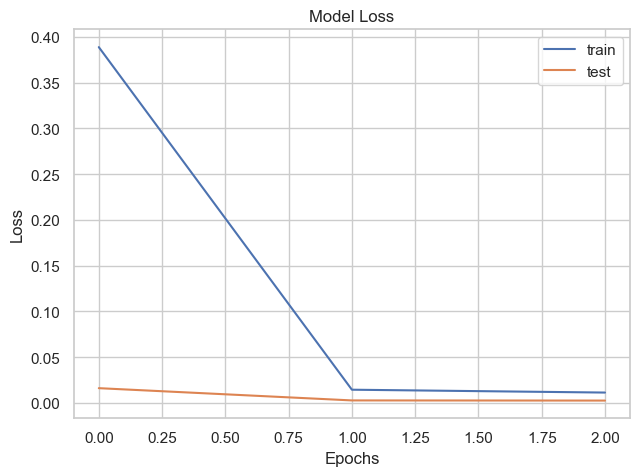

In [26]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

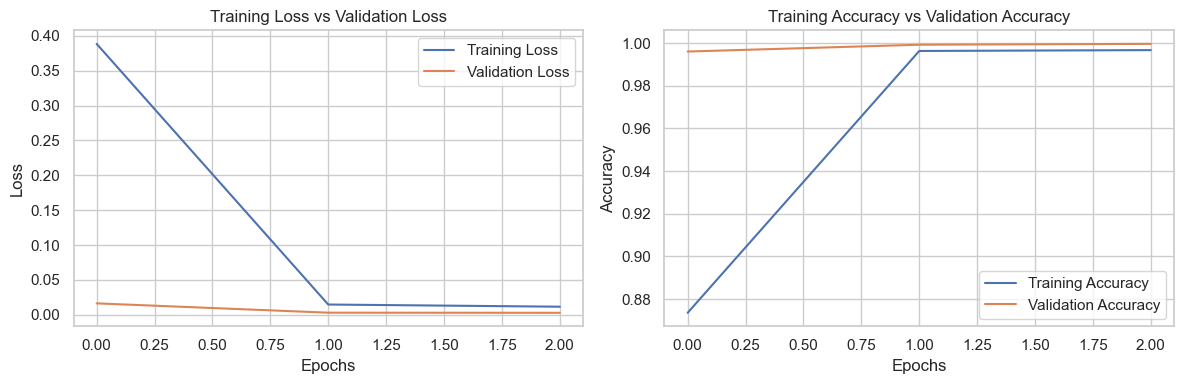

In [27]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(History.history['loss'], label='Training Loss')
plt.plot(History.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(History.history['accuracy'], label='Training Accuracy')
plt.plot(History.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 415ms/step


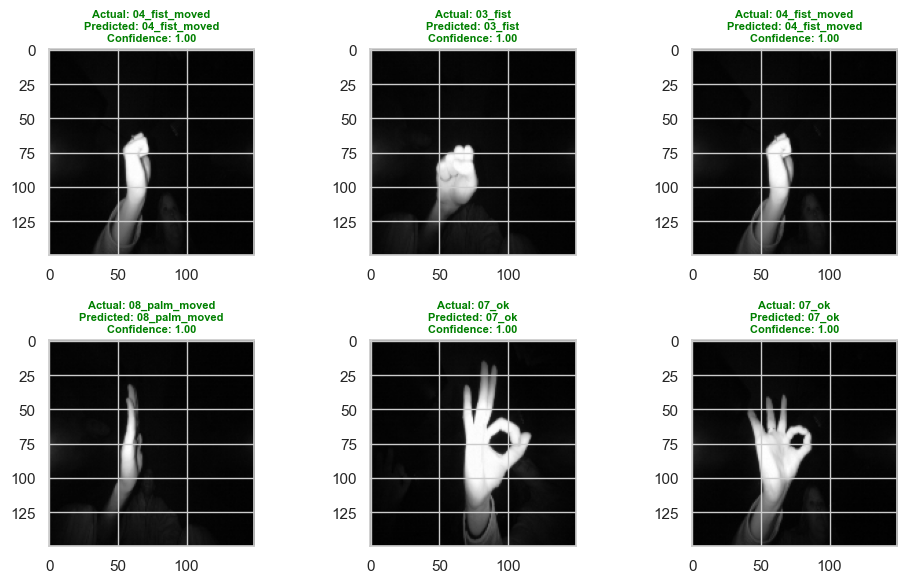

In [28]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Assuming you have a function to reverse lookup the class indices
def reverse_lookup(index):
    return reverselookup[index]

# Select random samples from the test set
num_samples_to_visualize = 6
random_indices = random.sample(range(len(x_test)), num_samples_to_visualize)
x_random_samples = x_test[random_indices]
y_random_labels = y_test[random_indices]  # Assuming y_test contains the true labels

# Make predictions on the randomly selected test samples
predictions_random = model.predict(x_random_samples)

# Visualize predictions for the randomly selected test samples in 2 rows
num_rows = 2
num_cols = num_samples_to_visualize // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        # Plot the original image
        axes[i, j].imshow(x_random_samples[index].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')

        # Print the confidence score in bold black color
        predicted_class = np.argmax(predictions_random[index])
        actual_class = np.argmax(y_random_labels[index])
        confidence = predictions_random[index][predicted_class]

        title_color = 'green' if predicted_class == actual_class else 'red'
        axes[i, j].set_title(f'Actual: {reverse_lookup(actual_class)}\nPredicted: {reverse_lookup(predicted_class)}\nConfidence: {confidence:.2f}', color=title_color, backgroundcolor='white', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

157/157 [==============================] - 15s 92ms/step


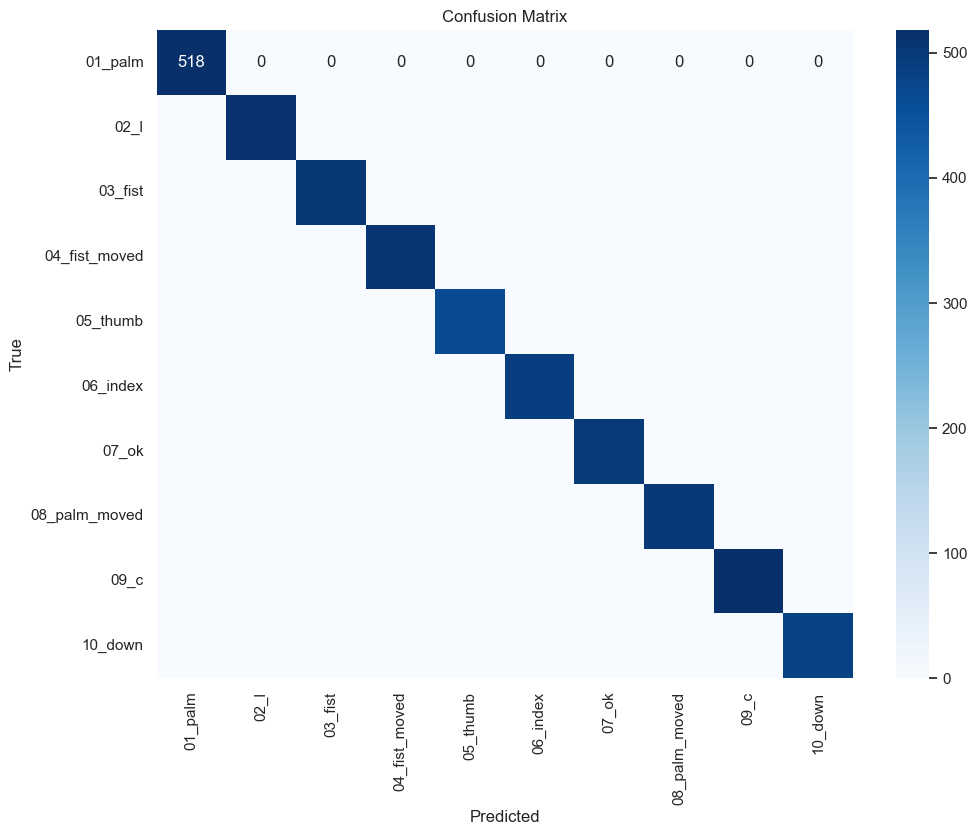

In [29]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=reverselookup.values(),
            yticklabels=reverselookup.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [42]:
from tensorflow.keras.models import load_model
import numpy as np
import json
# Load the model
loaded_model = load_model('hand_gesture_model.h5')

# Load the class indices
with open('hand_gesture_model_class_indices.json', 'r') as json_file:
    class_indices = json.load(json_file)

In [45]:
import cv2

# Open the camera
cap = cv2.VideoCapture(0)

window_name = 'Hand Gesture Recognition'
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)

# Set the desired window size
desired_window_size = (800, 600)
cv2.resizeWindow(window_name, *desired_window_size)

IMG_SIZE=150

while True:
    ret, frame = cap.read()

    # Preprocess the frame
    # Resize to the required input size of your model
    frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
    
    # Convert to grayscale if needed
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Normalize the pixel values
    normalized_frame = gray_frame / 255.0

    # Reshape the frame to match the model's input shape
    preprocessed_frame = normalized_frame.reshape((1, IMG_SIZE, IMG_SIZE, 1))

    # Make predictions on the preprocessed frame
    prediction = loaded_model.predict(preprocessed_frame)

    # Get the predicted class
    predicted_class = np.argmax(prediction)
    class_name = class_indices[str(predicted_class)]

    # Display the frame with prediction information
    cv2.putText(frame, f'Predicted: {reverse_lookup(predicted_class)}', (1, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('Hand Gesture Recognition', frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 20ms/step
